# Demo notebook for accessing NLCD data on Azure

This notebook provides an example of accessing NLCD (National Land Cover Database) data from blob storage on Azure, including (1) looking at the directory where data is stored, (2) load the cloud optimized geotiff for a aprticular year, and (3) doing some simple processing and plotting of the data.

The U.S. Geological Survey (USGS), in partnership with several federal agencies, has developed and released four National Land Cover Database (NLCD) products over the past two decades: NLCD 1992, 2001, 2006, and 2011. These products provide spatially explicit and reliable information on the Nation’s land cover and land cover change. 

In [59]:
import fsspec

import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr

In [49]:
# view the directory of available data 
account_name = 'carbonplan'  # change to your institution! 
container = 'carbonplan-data'  # change! 
area = 'conus'  # alaska can be accessed through 'ak'

fs = fsspec.get_filesystem_class('az')(account_name=account_name)
fs.ls(path=f'{container}/raw/nlcd/{area}/30m/')

['carbonplan-data/raw/nlcd/conus/30m/2001.tif',
 'carbonplan-data/raw/nlcd/conus/30m/2004.tif',
 'carbonplan-data/raw/nlcd/conus/30m/2006.tif',
 'carbonplan-data/raw/nlcd/conus/30m/2008.tif',
 'carbonplan-data/raw/nlcd/conus/30m/2011.tif',
 'carbonplan-data/raw/nlcd/conus/30m/2013.tif',
 'carbonplan-data/raw/nlcd/conus/30m/2016.tif',
 'carbonplan-data/raw/nlcd/conus/30m/change.tif']

In [42]:
# load data for a single year 
year = 2001
da = xr.open_rasterio(f'https://{account_name}.blob.core.windows.net/{container}/raw/nlcd/{area}/30m/{year}.tif', 
                      chunks=dict(x=2560, y=2560)) # a trick to use dask and chuck the data to get better performance 

# transform our data array to dataset by selecting the only data variable band 
# rename variable to something useful 
ds = da.to_dataset(dim='band').rename({1: 'landcover'})
ds

<xarray.Dataset>
Dimensions:    (x: 161190, y: 104424)
Coordinates:
  * y          (y) float64 3.31e+06 3.31e+06 3.31e+06 ... 1.773e+05 1.773e+05
  * x          (x) float64 -2.493e+06 -2.493e+06 ... 2.343e+06 2.343e+06
Data variables:
    landcover  (y, x) uint8 dask.array<chunksize=(2560, 2560), meta=np.ndarray>
Attributes:
    transform:           (30.0, 0.0, -2493045.0, 0.0, -30.0, 3310005.0)
    crs:                 +proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-...
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (nan,)
    scales:              (1.0,)
    offsets:             (0.0,)
    descriptions:        ('Layer_1',)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

In [68]:
# let's look at forest lands in the U.S. 
# land cover data are stored as categorical variables, and the legend for the code can be found in 
# https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend
# forest lands corresponds to codes 41, 42, and 43 
deciduous = ds.landcover.isin([41]).astype(int)
evergreen = ds.landcover.isin([42]).astype(int)
mixed = ds.landcover.isin([43]).astype(int)

# coarsen by 100x on each dimension to get to a reasonable plotting size 
factor = 100
deciduous = deciduous.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()
evergreen = evergreen.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()
mixed = mixed.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()

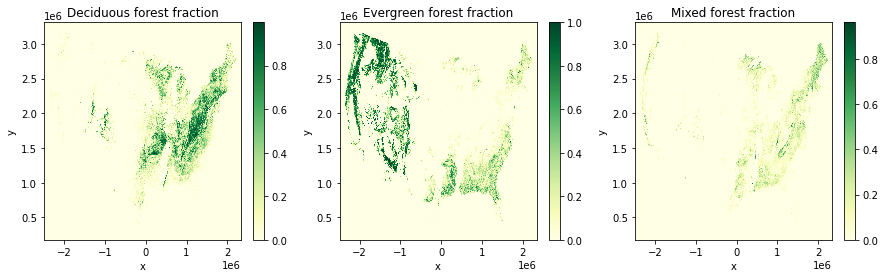

In [80]:
# let's now plot the different forests and see their distributions in the continental US 
plt.figure(figsize=(15,4))
ax = plt.subplot(1, 3, 1)
deciduous.plot(cmap='YlGn')
plt.title('Deciduous forest fraction')
plt.subplot(1, 3, 2)
evergreen.plot(cmap='YlGn')
plt.title('Evergreen forest fraction')
plt.subplot(1, 3, 3)
mixed.plot(cmap='YlGn')
plt.title('Mixed forest fraction')
plt.show()
plt.close()